This is a quick sample of basic Python operations to import data, clean them a little bit and then make some quick analysitcal operations.

Let's start by importing the libraries and the data

In [1]:
import numpy
import pandas
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import seaborn


dataset = "forestfires.csv"
fire_dataframe = pandas.read_csv(dataset, sep = ",")

Now, a quick analysis of the dataframe to see if it's well behaved

In [2]:
# inspect first rows
print("\nfirst rows:")
print(fire_dataframe.head(10))
# inspect dataframe summary
print("\ndataframe sumary:")
print(fire_dataframe.describe())
# inspect if there are NaNs
print("\ndataframe contains NaNs?")
print(fire_dataframe.isnull().values.any())


first rows:
   X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.0
5  8  6   aug  sun  92.3   85.3  488.0  14.7  22.2  29   5.4   0.0   0.0
6  8  6   aug  mon  92.3   88.9  495.6   8.5  24.1  27   3.1   0.0   0.0
7  8  6   aug  mon  91.5  145.4  608.2  10.7   8.0  86   2.2   0.0   0.0
8  8  6   sep  tue  91.0  129.5  692.6   7.0  13.1  63   5.4   0.0   0.0
9  7  5   sep  sat  92.5   88.0  698.6   7.1  22.8  40   4.0   0.0   0.0

dataframe sumary:
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mea

The dataframe has no NaNs, but it has some undesired features. First of all, the rain variable is basically always 0 except for a few cases. This makes this variable highly uninformative, so I will dropt it (NOTE: this behavior has been confirmed by running the same analysis without dropping the rain variable). Second undesired feature, the area variable is highly skewed toward zero. This is a problematic feature, as it requires a log-transform with an arbitrary small offset to properly model this system. For sake of simplicity, I will filter out fires that have an area of 0 acres. This is a gross simplification, but it will give me a sense of the most significant fires. I also convert the area into the log_area because it allows to deal better with the spread in area size.

In [3]:
fire_dataframe = fire_dataframe.drop("rain", axis = 1)
fire_dataframe = fire_dataframe[fire_dataframe["area"] > 0]
fire_dataframe["area"] = numpy.log(fire_dataframe["area"])

# inspect first rows
print("\nfirst rows:")
print(fire_dataframe.head(10))
# inspect dataframe summary
print("\ndataframe sumary:")
print(fire_dataframe.describe())
# inspect if there are NaNs
print("\ndataframe contains NaNs?")
print(fire_dataframe.isnull().values.any())


first rows:
     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind      area
138  9  9   jul  tue  85.8   48.3  313.4   3.9  18.0  42   2.7 -1.021651
139  1  4   sep  tue  91.0  129.5  692.6   7.0  21.7  38   2.2 -0.843970
140  2  5   sep  mon  90.9  126.5  686.5   7.0  21.9  39   1.8 -0.755023
141  1  2   aug  wed  95.5   99.9  513.3  13.2  23.3  31   4.5 -0.597837
142  8  6   aug  fri  90.1  108.0  529.8  12.5  21.2  51   8.9 -0.494296
143  1  2   jul  sat  90.0   51.3  296.3   8.7  16.6  53   5.4 -0.342490
144  2  5   aug  wed  95.5   99.9  513.3  13.2  23.8  32   5.4 -0.261365
145  6  5   aug  thu  95.2  131.7  578.8  10.4  27.4  22   4.0 -0.105361
146  5  4   mar  mon  90.1   39.7   86.6   6.2  13.2  40   5.4 -0.051293
147  8  3   sep  tue  84.4   73.4  671.9   3.2  24.2  28   3.6 -0.040822

dataframe sumary:
                X           Y        FFMC         DMC          DC         ISI  \
count  270.000000  270.000000  270.000000  270.000000  270.000000  270.000000   
mea

After the filtering, i rescale and normalize the continous variables and put them in a scatterplots so to see how outliers will affect the modeling effort

AxesSubplot(0.125,0.125;0.775x0.755)


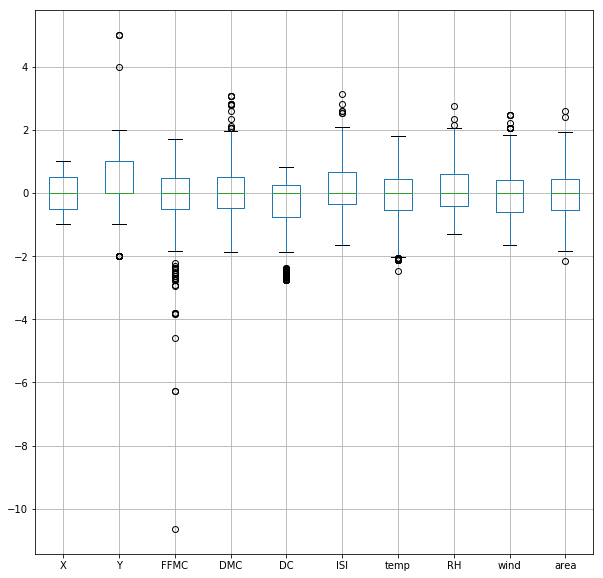

In [4]:
# rescale non-factor variables
temp = fire_dataframe.drop(["month", "day"], axis = 1)
normalized_fire_dataframe = pandas.DataFrame(preprocessing.robust_scale(temp), columns = temp.columns)

# boxplots of continuous variables
dataframe_boxplot_1 = normalized_fire_dataframe.boxplot(figsize=(10, 10))
print(dataframe_boxplot_1)

This indicates that there are outliers, especially in some indicators, but nothing that makes the analysis unmaneagable. Now, let's have if there are easy to spot correlations between the data with a scatterplot and the correlation matrix

             X         Y      FFMC       DMC        DC       ISI      temp  \
X     1.000000  0.497039 -0.072176 -0.104614 -0.161281 -0.054832 -0.081485   
Y     0.497039  1.000000 -0.021123  0.037533 -0.034065 -0.071683  0.031705   
FFMC -0.072176 -0.021123  1.000000  0.480250  0.407638  0.704170  0.562256   
DMC  -0.104614  0.037533  0.480250  1.000000  0.668926  0.329656  0.501643   
DC   -0.161281 -0.034065  0.407638  0.668926  1.000000  0.256826  0.495703   
ISI  -0.054832 -0.071683  0.704170  0.329656  0.256826  1.000000  0.466027   
temp -0.081485  0.031705  0.562256  0.501643  0.495703  0.466027  1.000000   
RH    0.064763 -0.039081 -0.285990  0.027861 -0.082217 -0.148804 -0.497548   
wind  0.042686 -0.037208 -0.161384 -0.137897 -0.237593  0.072652 -0.320563   
area  0.019832 -0.011719 -0.045433  0.029488 -0.029071 -0.110253 -0.034502   

            RH      wind      area  
X     0.064763  0.042686  0.019832  
Y    -0.039081 -0.037208 -0.011719  
FFMC -0.285990 -0.161384 -0.04

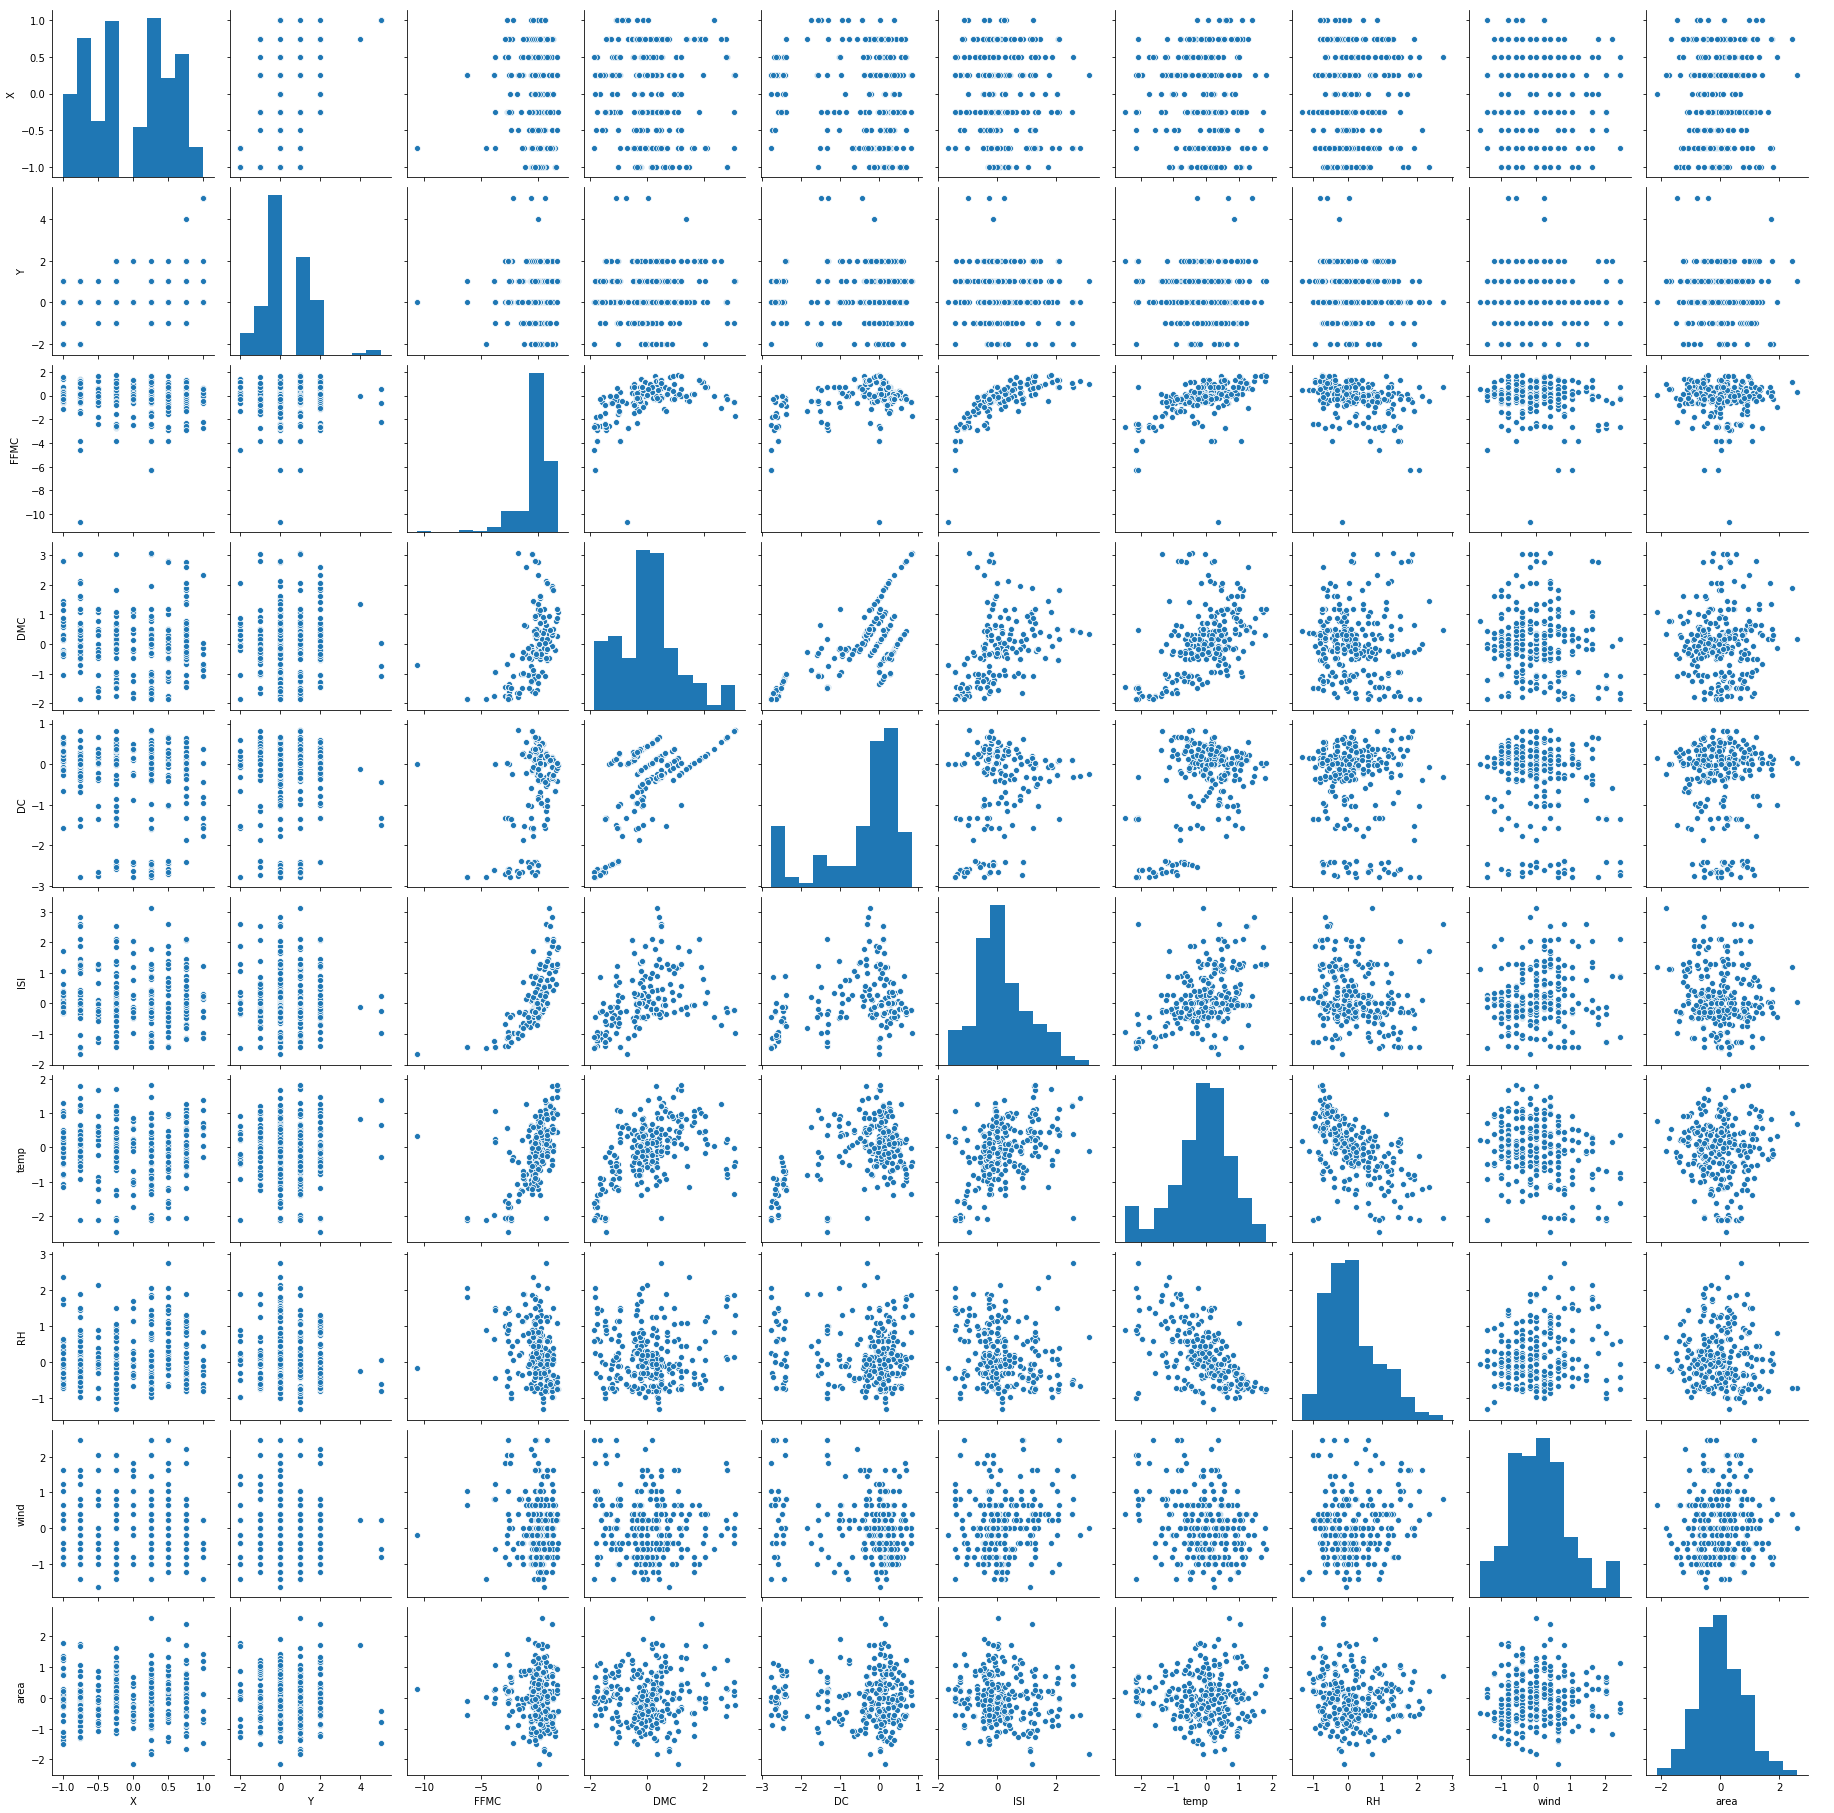

In [5]:
print(seaborn.pairplot(normalized_fire_dataframe))
print(normalized_fire_dataframe.corr())

To me, it looks like that there are no clear correlations between the area and the other variables (which is what I might be interested in). However, I see that some of the non-area variables are correlated to each other. This indicates that a pricipal component analysis should be put in place to remove these correlations, and, possibly, highlight some behavior that is hidden from data correlations. To this end, I first check how much variability of the data I need to explain 75% of the total data variability.

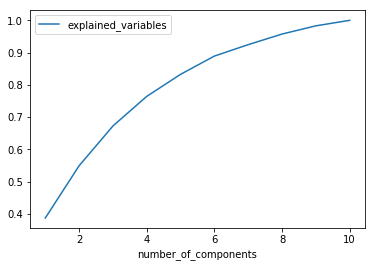

In [6]:
pca_normalized_fire_dataframe = PCA(n_components=10).fit(normalized_fire_dataframe)
explained_variables = pandas.DataFrame({"number_of_components" : range(1,11), "explained_variables" : pca_normalized_fire_dataframe.explained_variance_ratio_.cumsum()})
explained_variables.plot(x = "number_of_components", y = "explained_variables")

Which indicates that I can explain 75% of the data variability with the first 4 principal components. Increasing the number of components does not give additional advantages.

After performing the pca decomposition, I redo the scatterplots and correlation analysis for the PCA dataset

               PC1           PC2           PC3           PC4      area
PC1   1.000000e+00 -1.616186e-16 -1.165287e-16 -1.065094e-16  0.054127
PC2  -1.616186e-16  1.000000e+00 -4.179486e-16  2.064503e-16 -0.003515
PC3  -1.165287e-16 -4.179486e-16  1.000000e+00  2.588283e-16  0.089990
PC4  -1.065094e-16  2.064503e-16  2.588283e-16  1.000000e+00  0.026012
area  5.412722e-02 -3.515458e-03  8.999009e-02  2.601200e-02  1.000000


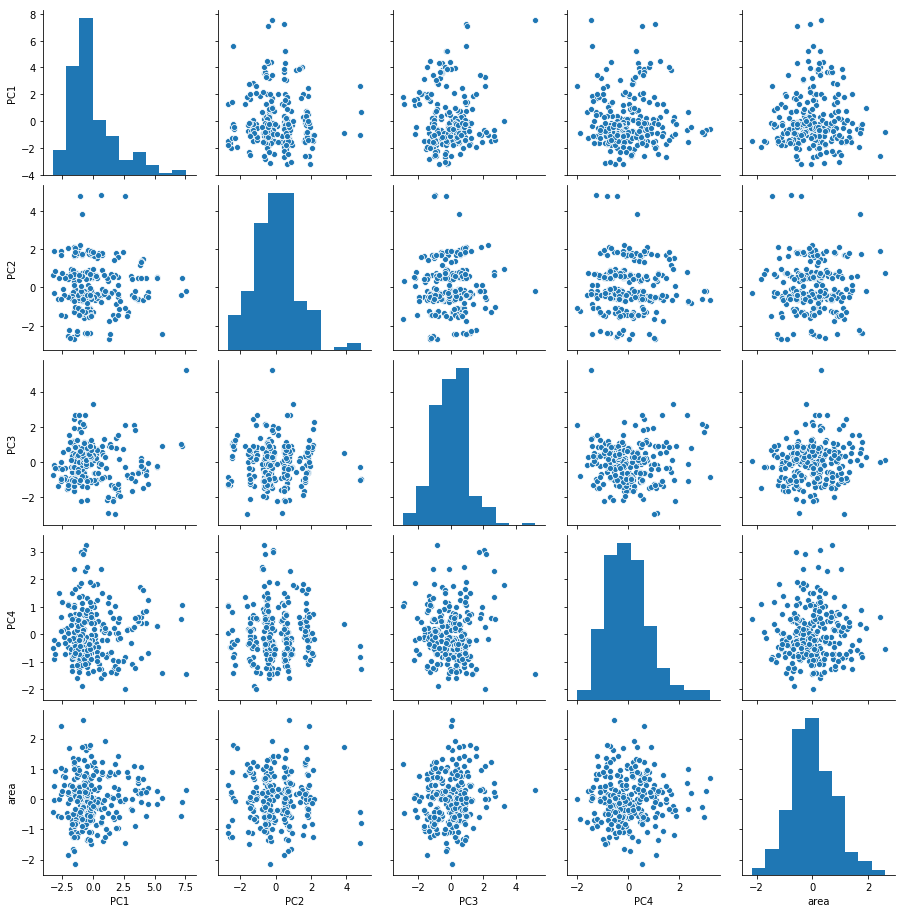

In [7]:
# perform pca
pca_normalized_fire_dataframe = pandas.DataFrame(PCA(n_components=4).fit_transform(normalized_fire_dataframe), columns = ("PC1", "PC2", "PC3", "PC4"))

# recover area infomration
pca_normalized_fire_dataframe["area"] = normalized_fire_dataframe["area"]

# scatterplots and correlations
print(seaborn.pairplot(pca_normalized_fire_dataframe))
print(pca_normalized_fire_dataframe.corr())


Overall, this analysis suggests that the Principal components of the explanatory variables have no correlation with the fire area. This is a bit surprising, which implies that I need to to double check my analysis and ensure that I am not having confounder effects in my analysis. I also suspect that adding explanatory variables with so little variation as the rain may have compromised my analysis.

Now, as a last part, I just want to train a linear regression model to see how it is done in python. I will focus on the relation between temperature (temp) and relative humidity (RH) so that I can check more easily. This is more of a dummy code than a meaningfull analysis

[-0.03183621]
[[-0.56050336]]


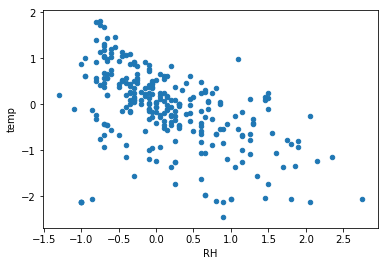

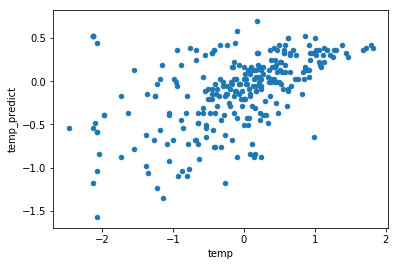

In [8]:
normalized_fire_dataframe.plot.scatter(x = "RH", y = "temp")

RH = normalized_fire_dataframe["RH"].values.reshape(-1,1)
temp = normalized_fire_dataframe["temp"].values.reshape(-1,1)

linear_model_temp_vs_RH = LinearRegression().fit(RH, temp)
print(linear_model_temp_vs_RH.intercept_)
print(linear_model_temp_vs_RH.coef_)


normalized_fire_dataframe["temp_predict"]=linear_model_temp_vs_RH.predict(RH).flatten()
normalized_fire_dataframe.plot.scatter(x = "temp", y = "temp_predict")


